In [1]:
from rlboard import *

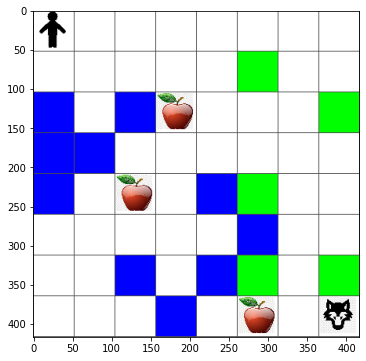

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

In [8]:
print(action_idx)

{'U': 0, 'D': 1, 'L': 2, 'R': 3}


In [9]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)


18

In [10]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


In [14]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

In [15]:
def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

In [21]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

C:\Users\sloth\AppData\Local\Temp/ipykernel_10336/3481979724.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)


In [22]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [24]:
from IPython.display import clear_output

lpath = []

for epoch in range(5000):
    
        # Pick initial point
        m.random_start()
        
        # Start travelling
        n=0
        cum_reward = 0
        while True:
            x,y = m.human
            v = probs(Q[x,y])
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
            r = reward(m)
            cum_reward += r
            if r==end_reward or cum_reward < -1000:
                lpath.append(n)
                break
            alpha = np.exp(-n / 10e5)
            gamma = 0.5
            ai = action_idx[a]
            Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
            n+=1

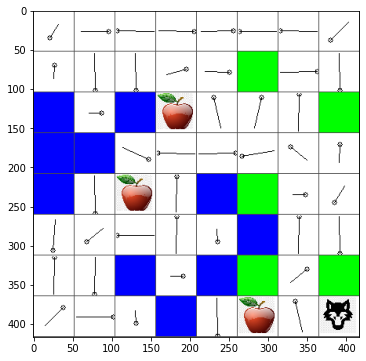

In [26]:
m.plot(Q)

In [ ]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

In [28]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 5.21, eaten by wolf: 0 times
